In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import grid_evaluate
from sklearn.neural_network import MLPClassifier


#Load the saved CSVs
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')


#Squeeze to make them series
y_train = y_train.squeeze()
y_test = y_test.squeeze()


#Define the base model
base_clf = MLPClassifier(
    max_iter=1000,
    random_state=42
)


param_grid = {

    'hidden_layer_sizes': [(15,), (20,), (15,15)],
    'activation':         ['relu', 'tanh'],
    'alpha':              [1e-4, 1e-3], #L2 penalty (weight decay)
    'learning_rate_init': [1e-3, 1e-2],
}


results_nn = grid_evaluate(
    estimator  = base_clf,
    param_grid = param_grid,
    X_train    = X_train,
    X_test     = X_test,
    y_train    = y_train,
    y_test     = y_test
)

#drop unnecessary columns (not modified in neural network model)
results_nn = results_nn.drop(
    columns=['feature_method','degree','n_components','gamma'],
    errors='ignore'   # won’t error out if any are already missing
)

#Inspect best model by F1
best_nn = results_nn.sort_values('f1_score', ascending=False)
print(best_nn.iloc[0])
print(best_nn)


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_m

accuracy                 0.728
precision             0.448276
recall                0.419355
f1_score              0.433333
activation                relu
alpha                    0.001
hidden_layer_sizes    (15, 15)
learning_rate_init        0.01
Name: 11, dtype: object
    accuracy  precision    recall  f1_score activation   alpha  \
11     0.728   0.448276  0.419355  0.433333       relu  0.0010   
10     0.728   0.444444  0.387097  0.413793       relu  0.0010   
4      0.732   0.450980  0.370968  0.407080       relu  0.0001   
5      0.720   0.428571  0.387097  0.406780       relu  0.0001   
8      0.736   0.454545  0.322581  0.377358       relu  0.0010   
2      0.736   0.452381  0.306452  0.365385       relu  0.0001   
16     0.664   0.342857  0.387097  0.363636       tanh  0.0001   
0      0.732   0.441860  0.306452  0.361905       relu  0.0001   
22     0.660   0.338028  0.387097  0.360902       tanh  0.0010   
1      0.668   0.338462  0.354839  0.346457       relu  0.0001   
18

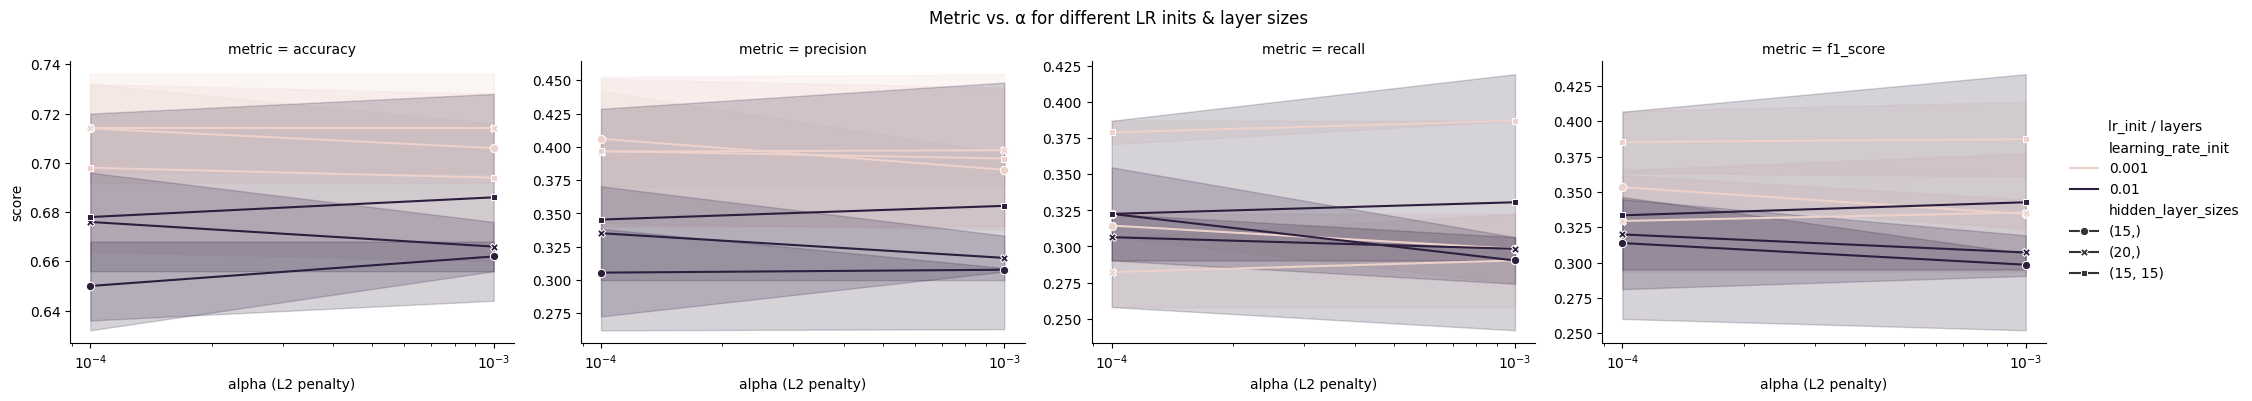

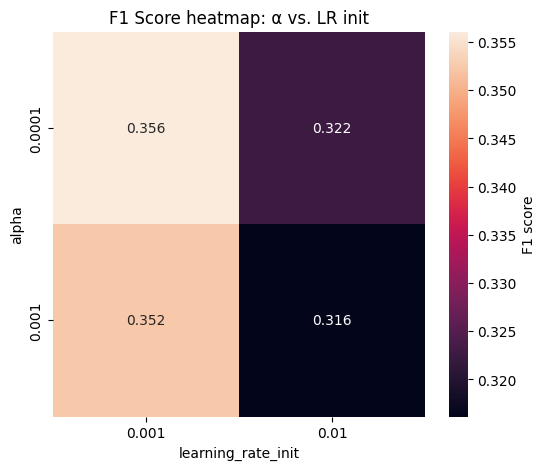

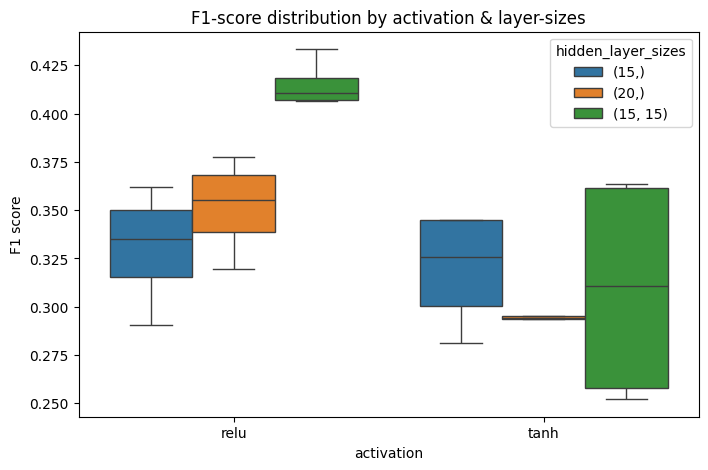

In [14]:

df = results_nn.reset_index(drop=True)


#melting df for easier plotting
metrics = ['accuracy','precision','recall','f1_score']
df_long = df.melt(
    id_vars=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)

#using sns to visualize the results
g = sns.FacetGrid(
    df_long, 
    col='metric', 
    sharey=False, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.lineplot,
    x='alpha', 
    y='score',
    hue='learning_rate_init',
    style='hidden_layer_sizes',
    markers=True,
    dashes=False
)

g.set(xscale='log') #log scale to visualize alpha better
g.add_legend(title='lr_init / layers')
g.set_axis_labels('alpha (L2 penalty)','score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Metric vs. α for different LR inits & layer sizes')
plt.show()


#heatmap of F1-score over (alpha, learning_rate_init)

pivot_f1 = df.pivot_table(
    index='alpha', 
    columns='learning_rate_init', 
    values='f1_score'
)

plt.figure(figsize=(6,5))
sns.heatmap(
    pivot_f1, 
    annot=True, 
    fmt=".3f", 
    cbar_kws={'label':'F1 score'}
)
plt.title('F1 Score heatmap: α vs. LR init')
plt.xlabel('learning_rate_init')
plt.ylabel('alpha')
plt.show()


#activation comparison
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_long[df_long.metric=='f1_score'],
    x='activation',
    y='score',
    hue='hidden_layer_sizes'
)
plt.title('F1-score distribution by activation & layer-sizes')
plt.ylabel('F1 score')
plt.show()
